In [1]:
import torch
import tenseal as ts
import pandas as pd
import random
from time import time

# those are optional and are not necessary for training
import numpy as np
import matplotlib.pyplot as plt

from torchmetrics.classification import BinaryAccuracy
accuracy = BinaryAccuracy()


In [2]:
# parameters
param = [4096,8192][1]
n_parts = 16

if param==4096:
    poly_mod_degree = 4096
    coeff_mod_bit_sizes = [40, 20, 40]
    context = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
    context.global_scale = 2 ** 20
else:
    poly_mod_degree = 8192
    #coeff_mod_bit_sizes = [40, 21, 21, 21, 21, 21, 21, 40]
    coeff_mod_bit_sizes = [60,40,40,60]
    context = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
    #context.global_scale = 2 ** 21
    context.global_scale = 2 ** 40
    
# this key is needed for doing dot-product operations
context.generate_galois_keys()


In [3]:
df = pd.read_csv("./data/myTenYearCHD_n1000.csv", index_col=0)
df.head()


,male,age,cigsPerDay,prevalentStroke,prevalentHyp,totChol,sysBP,heartRate,glucose,TenYearCHD
521,1.057131,-1.116420,0.894010,-0.083918,-0.792487,0.053780,-0.758911,-0.622219,-0.309160,1
737,1.057131,-1.116420,0.894010,-0.083918,-0.792487,-0.312693,-1.083813,-0.869361,-0.216819,1
740,-0.945011,-0.538324,-0.756825,-0.083918,-0.792487,-0.198170,0.012732,-0.045556,-0.247599,1
660,-0.945011,1.311586,-0.756825,-0.083918,1.260588,1.542577,2.368274,-0.045556,0.090987,1
411,1.057131,-0.653943,0.894010,-0.083918,1.260588,0.328635,0.906213,-0.951741,-0.432283,0


In [4]:
train_len = 800
part_len = train_len//n_parts

X_trn = torch.tensor(df.iloc[:train_len,:-1].values).float().split(part_len)
Y_trn = torch.tensor(df.iloc[:train_len,-1:].values).float().split(part_len)
X_tst = torch.tensor(df.iloc[train_len:,:-1].values).float()
Y_tst = torch.tensor(df.iloc[train_len:,-1:].values).float()

print(f"X_trn has size: {X_trn[0].shape}")
print(f"Y_trn has size: {Y_trn[0].shape}")
print(f"X_tst has size: {X_tst.shape}")
print(f"Y_tst has size: {Y_tst.shape}")


X_trn has size: torch.Size([50, 9])
Y_trn has size: torch.Size([50, 1])
X_tst has size: torch.Size([200, 9])
Y_tst has size: torch.Size([200, 1])


In [5]:
class LR(torch.nn.Module):

    def __init__(self, n_features):
        super(LR, self).__init__()
        self.lr = torch.nn.Linear(n_features, 1)
        
    def forward(self, x):
        out = torch.sigmoid(self.lr(x))
        return out


In [6]:
def addition_tree(parts):
    n = len(parts)
    if n==1:
        return parts[0]
    elif n%2==0:
        return addition_tree(parts[:n//2]) + addition_tree(parts[n//2:]) 
    else:
        print("Error: length must power of 2")
        return None
    
addition_tree([1,2,3,4]), addition_tree(Y_trn).shape  
#addition_tree([model.weight() for model in models])   
#addition_tree([model.bias() for model in models])   


(10, torch.Size([50, 1]))

In [7]:
n_features = X_trn[0].shape[1]
n_epochs = 5

# use Binary Cross Entropy Loss
criterion = torch.nn.BCELoss()

def train_distr(context = None, verbose = True):
    models = [LR(n_features) for i in range(n_parts)]
    optims = [torch.optim.SGD(model.parameters(), lr=1) for model in models]
    for i in range(n_epochs):
        # Each part takes a gradient step to modify params based on their data
        for j in range(n_parts):
            optims[j].zero_grad()
            out = models[j](X_trn[j])
            loss = criterion(out, Y_trn[j])
            if verbose:
                print(f"Epoch {i} loss for part {j}: {loss.data}")
            loss.backward()
            optims[j].step()
        weights = [model.state_dict()["lr.weight"]/n_parts for model in models]
        biases = [model.state_dict()["lr.bias"]/n_parts for model in models]
        if context is not None:
            # Each partys new params are encrypted before sharing
            weights = [ts.ckks_vector(context, w.tolist()[0]) for w in weights]
            biases = [ts.ckks_vector(context, b.tolist()) for b in biases]
        # Aggregate (encrypted) params accross federation 
        aggr_weight = addition_tree(weights)
        aggr_bias = addition_tree(biases)
        if context is not None:
            # Coordinating party receives aggregates and decrypts
            aggr_weight = torch.tensor(aggr_weight.decrypt())[None,:]
            aggr_bias = torch.tensor(aggr_bias.decrypt())
        state_dict = models[0].state_dict().copy()
        state_dict["lr.weight"] = aggr_weight
        state_dict["lr.bias"] = aggr_bias        
        # Aggregate params are shared with all parts who update their model
        for model in models:
            model.load_state_dict(state_dict.copy())
    return models


## Distributed training with plain text aggregation

In [8]:
plain_models = train_distr()
#models = train_distr(context)

for j, model in enumerate(plain_models):
    out = model(X_trn[j])
    loss = criterion(out, Y_trn[j])
    print(f"Epoch {n_epochs} loss for part {j}: {loss.data}")

plain_prediction = plain_models[0](X_tst)
plain_accuracy = accuracy(plain_prediction,Y_tst)
print(f"Plain model accuracy on test set: {plain_accuracy}")
    

Epoch 0 loss for part 0: 0.6994999647140503
Epoch 0 loss for part 1: 0.779744029045105
Epoch 0 loss for part 2: 0.686612069606781
Epoch 0 loss for part 3: 0.7127335071563721
Epoch 0 loss for part 4: 0.6862804889678955
Epoch 0 loss for part 5: 0.6910325884819031
Epoch 0 loss for part 6: 0.7224551439285278
Epoch 0 loss for part 7: 0.6863911151885986
Epoch 0 loss for part 8: 0.7961196899414062
Epoch 0 loss for part 9: 0.8586344718933105
Epoch 0 loss for part 10: 0.7902467250823975
Epoch 0 loss for part 11: 0.669370174407959
Epoch 0 loss for part 12: 0.7689077854156494
Epoch 0 loss for part 13: 0.6135224103927612
Epoch 0 loss for part 14: 0.6536352038383484
Epoch 0 loss for part 15: 0.735402524471283
Epoch 1 loss for part 0: 0.6083904504776001
Epoch 1 loss for part 1: 0.6377728581428528
Epoch 1 loss for part 2: 0.6071103811264038
Epoch 1 loss for part 3: 0.646403968334198
Epoch 1 loss for part 4: 0.6330026984214783
Epoch 1 loss for part 5: 0.6080554723739624
Epoch 1 loss for part 6: 0.6192

## Distributed training with encypted aggregation

In [9]:
crypt_models = train_distr(context)

for j, model in enumerate(crypt_models):
    out = model(X_trn[j])
    loss = criterion(out, Y_trn[j])
    print(f"Epoch {n_epochs} loss for part {j}: {loss.data}")

crypt_prediction = crypt_models[0](X_tst)
crypt_accuracy = accuracy(crypt_prediction,Y_tst)
print(f"Plain model accuracy on test set: {crypt_accuracy}")


Epoch 0 loss for part 0: 0.7848076820373535
Epoch 0 loss for part 1: 0.6517206430435181
Epoch 0 loss for part 2: 0.6582260131835938
Epoch 0 loss for part 3: 0.7966941595077515
Epoch 0 loss for part 4: 0.7684285044670105
Epoch 0 loss for part 5: 0.7467472553253174
Epoch 0 loss for part 6: 0.6774566173553467
Epoch 0 loss for part 7: 0.6403069496154785
Epoch 0 loss for part 8: 0.86881422996521
Epoch 0 loss for part 9: 0.7887939214706421
Epoch 0 loss for part 10: 0.8129478693008423
Epoch 0 loss for part 11: 0.686836838722229
Epoch 0 loss for part 12: 0.6637439131736755
Epoch 0 loss for part 13: 0.851500391960144
Epoch 0 loss for part 14: 0.7210556268692017
Epoch 0 loss for part 15: 0.6592033505439758
Epoch 1 loss for part 0: 0.6193786859512329
Epoch 1 loss for part 1: 0.6465803384780884
Epoch 1 loss for part 2: 0.6118760108947754
Epoch 1 loss for part 3: 0.6543110013008118
Epoch 1 loss for part 4: 0.6435315012931824
Epoch 1 loss for part 5: 0.6136972904205322
Epoch 1 loss for part 6: 0.628

## Collect stats for training and evaluation

In [10]:
tst = []

verbose = False

for i in range(100):
    row = []
    
    t0 = time()
    plain_models = train_distr(verbose=False)
    row.append(time()-t0)
    
    plain_prediction = plain_models[0](X_tst)
    plain_accuracy = accuracy(plain_prediction,Y_tst).tolist()
    row.append(plain_accuracy)
    
    t1 = time()
    crypt_models = train_distr(context,verbose=False)
    row.append(time()-t1)

    crypt_prediction = crypt_models[0](X_tst)
    crypt_accuracy = accuracy(crypt_prediction,Y_tst).tolist()
    row.append(crypt_accuracy)
    
    weight = plain_models[0].state_dict()["lr.weight"]
    bias = plain_models[0].state_dict()["lr.bias"]
    t1 = time()
    weight = ts.ckks_vector(context, weight.tolist()[0])
    bias = ts.ckks_vector(context, bias.tolist())
    row.append(time()-t1)

    t1 = time()
    weight = addition_tree([weight, weight])
    bias = addition_tree([bias, bias])
    row.append(time()-t1)

    t1 = time()
    weight.decrypt()
    bias.decrypt()
    row.append(time()-t1)
    
    tst.append(row)
    print(f"Round {i+1} completed in {time()-t0}")

res = pd.DataFrame(tst, columns=["plain_time","plain_acc","crypt_time","crypt_acc",
                                                    "enc_time","add_time","dec_time"])
res

Round 1 completed in 0.854276180267334
Round 2 completed in 0.8455915451049805
Round 3 completed in 0.8528392314910889
Round 4 completed in 0.8531560897827148
Round 5 completed in 0.8429346084594727
Round 6 completed in 1.1383888721466064
Round 7 completed in 0.8439013957977295
Round 8 completed in 0.8419866561889648
Round 9 completed in 0.8569252490997314
Round 10 completed in 0.8497653007507324
Round 11 completed in 0.8583364486694336
Round 12 completed in 0.8349559307098389
Round 13 completed in 0.8429200649261475
Round 14 completed in 0.8238818645477295
Round 15 completed in 0.836540699005127
Round 16 completed in 0.8185255527496338
Round 17 completed in 0.834221601486206
Round 18 completed in 0.8495693206787109
Round 19 completed in 0.8367323875427246
Round 20 completed in 0.8377792835235596
Round 21 completed in 0.8388807773590088
Round 22 completed in 0.8276822566986084
Round 23 completed in 0.8342249393463135
Round 24 completed in 0.818690299987793
Round 25 completed in 0.83672

,plain_time,plain_acc,crypt_time,crypt_acc,enc_time,add_time,dec_time
0,0.029598,0.695,0.810643,0.690,0.009646,0.000160,0.002671
1,0.023603,0.695,0.807364,0.690,0.010152,0.000189,0.002692
2,0.029071,0.690,0.808878,0.700,0.010103,0.000159,0.002733
3,0.023854,0.695,0.814939,0.695,0.009673,0.000151,0.002710
4,0.023590,0.685,0.805275,0.695,0.009691,0.000155,0.002640
...,...,...,...,...,...,...,...
95,0.033175,0.685,0.835812,0.685,0.009774,0.000156,0.002850
96,0.027248,0.700,0.801550,0.670,0.009358,0.000132,0.002603
97,0.022916,0.695,0.786927,0.700,0.009298,0.000136,0.002608
98,0.020993,0.705,0.761863,0.700,0.009281,0.000133,0.002609


In [11]:
tmp = res.describe()
tmp.to_csv(f"figs/stats_distr_{param}_{n_parts}.csv")
tmp


,plain_time,plain_acc,crypt_time,crypt_acc,enc_time,add_time,dec_time
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.024849,0.691850,0.798279,0.692250,0.009645,0.000145,0.002648
std,0.003978,0.008308,0.032480,0.007732,0.001335,0.000032,0.000195
min,0.020993,0.670000,0.761863,0.670000,0.008878,0.000129,0.002452
25%,0.022659,0.685000,0.785700,0.688750,0.009297,0.000135,0.002594
50%,0.023596,0.690000,0.796864,0.695000,0.009431,0.000137,0.002624
75%,0.026246,0.700000,0.804816,0.700000,0.009632,0.000142,0.002673
max,0.048742,0.710000,1.074542,0.705000,0.020614,0.000430,0.004281


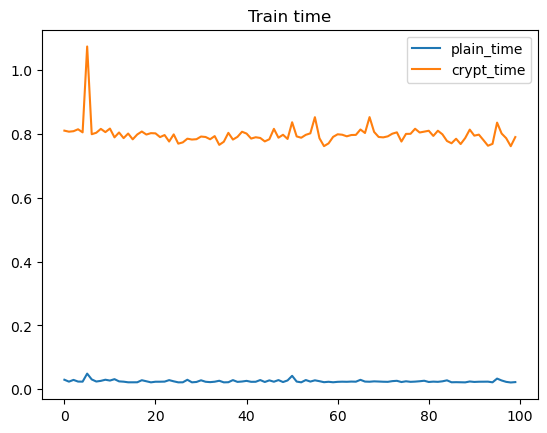

In [12]:
res.iloc[:,[0,2]].plot()
plt.legend()
plt.title("Train time")
plt.savefig(f"figs/traintime_distr_{param}_{n_parts}.png")
plt.show()


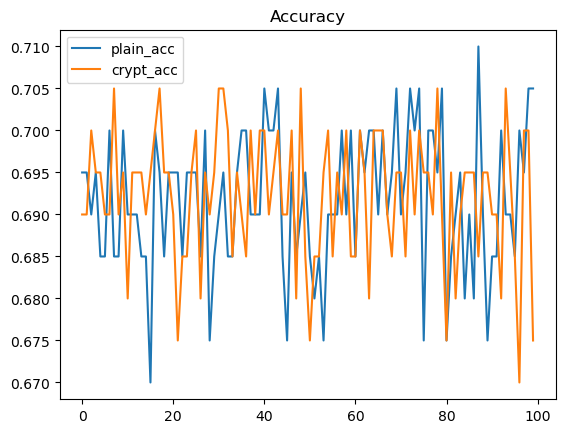

In [13]:
res.iloc[:,[1,3]].plot()
plt.legend()
plt.title("Accuracy")
plt.savefig(f"figs/accuracy_distr_{param}_{n_parts}.png")
plt.show()


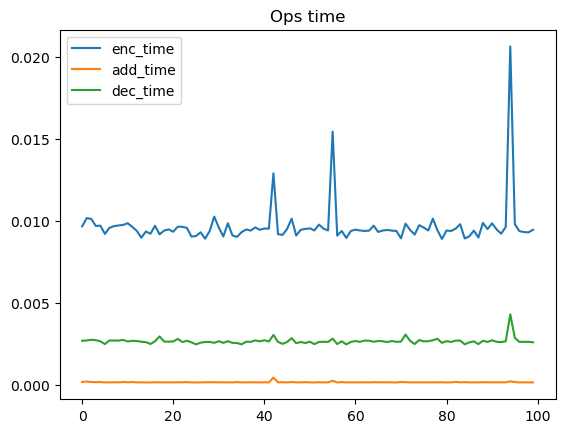

In [14]:
res.iloc[:,4:].plot()
plt.legend()
plt.title("Ops time")
plt.savefig(f"figs/ops_time_distr_{param}_{n_parts}.png")
plt.show()


In [15]:
res.to_csv(f"figs/results_distr_{param}_{n_parts}.csv")
